In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import sklearn
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
import tensorflow_datasets as tfds
# subword-level model
dataset, info = tfds.load('imdb_reviews/subwords8k',with_info=True,as_supervised=True)
train_dataset , test_dataset = dataset['train'],dataset['test']
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [3]:
# subword
tokenizer = info.features['text'].encoder
print('vocabulary size: {}'.format(tokenizer.vocab_size))


vocabulary size: 8185


In [4]:
# word -> subword
sample_string = "Tensorflow is cool."
tokenized_string = tokenizer.encode(sample_string) 
print('tokenized string is {}'.format(tokenized_string))
original_string = tokenizer.decode(tokenized_string)
print('original string is {}'.format(original_string))

tokenized string is [6307, 2327, 2934, 7961, 9, 2724, 7975]
original string is Tensorflow is cool.


In [5]:
for token in tokenized_string:
    print('{} --> "{}"'.format(token,tokenizer.decode([token])))

6307 --> "Ten"
2327 --> "sor"
2934 --> "flow"
7961 --> " "
9 --> "is "
2724 --> "cool"
7975 --> "."


In [6]:
buffer_size = 10000
batch_size = 64
# dataset.padded_batch
train_dataset = train_dataset.shuffle(buffer_size)
#train_dataset = train_dataset.padded_batch(batch_size,train_dataset.output_shapes)
#test_dataset = test_dataset.padded_batch(batch_szie,test_dataset.output_shapes)
train_dataset = train_dataset.padded_batch(batch_size,tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(batch_size,tf.compat.v1.data.get_output_shapes(test_dataset))

print(tf.compat.v1.data.get_output_shapes(train_dataset))
print(tf.compat.v1.data.get_output_shapes(test_dataset))


(TensorShape([None, None]), TensorShape([None]))
(TensorShape([None, None]), TensorShape([None]))


In [7]:
# 双向 循环网络
embedding_dim = 16
batch_size = 128
varcob_size = tokenizer.vocab_size
# keras.layers.Bidirectional
# keras.layers.SimpleRNN
bidir_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(varcob_size,embedding_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(units=32,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(units=32,return_sequences=False)),#因为后面是全连接层 故而 False
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

bidir_rnn_model.summary()
bidir_rnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          12544     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 170,449
Trainable params: 170,449
Non-trainable params: 0
_________________________________________________________________


In [8]:
epochs =5
history = bidir_rnn_model.fit(train_dataset,epochs=epochs,validation_data=test_dataset)


Epoch 1/5
391/391 [==============================] - 3047s 8s/step - loss: 0.6470 - accuracy: 0.6238 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
391/391 [==============================] - 2997s 8s/step - loss: 0.5398 - accuracy: 0.7304 - val_loss: 0.7549 - val_accuracy: 0.6624
Epoch 3/5
391/391 [==============================] - 3395s 9s/step - loss: 0.4824 - accuracy: 0.7893 - val_loss: 0.5329 - val_accuracy: 0.7520
Epoch 4/5
391/391 [==============================] - 3251s 8s/step - loss: 0.4704 - accuracy: 0.7814 - val_loss: 0.5065 - val_accuracy: 0.7364
Epoch 5/5
391/391 [==============================] - 3441s 9s/step - loss: 0.3917 - accuracy: 0.8336 - val_loss: 0.4744 - val_accuracy: 0.7956


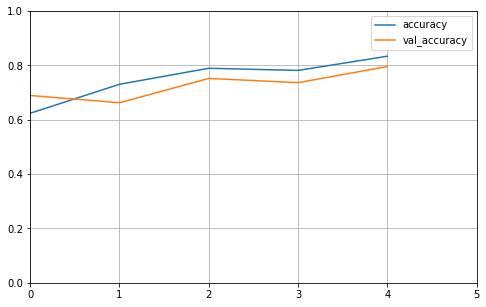

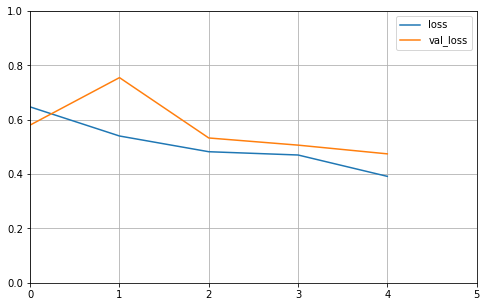

In [9]:
def plot_leraning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_leraning_curves(history, 'accuracy', epochs, 0, 1)
plot_leraning_curves(history, 'loss', epochs, 0, 1)

In [10]:
bidir_rnn_model.evaluate(test_dataset)

391/391 [==============================] - 234s 598ms/step - loss: 0.4744 - accuracy: 0.7956


[0.4744124162532484, 0.7956]